In [6]:
import os
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.functional as F


[[ 7274.  5237.  5033.]
 [ 2255. 88260.  2139.]
 [ 4734.  6365.  8040.]]


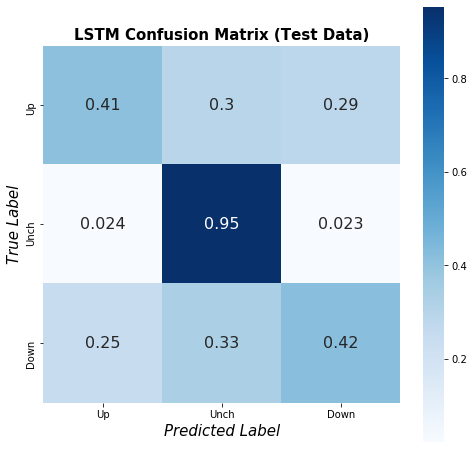

In [7]:
cm = np.asarray([[ 7274,5237,5033],
 [2255,88260,2139],
 [4734,6365,8040]])

cm = cm.astype(float)
print(cm)

cm[0,:] = np.true_divide(cm[0,:], cm[0,:].sum())
cm[1,:] = np.true_divide(cm[1,:], cm[1,:].sum())
cm[2,:] = np.true_divide(cm[2,:], cm[2,:].sum())


import seaborn as sns

fig, axs = plt.subplots(1, figsize = (8,8))
axs = sns.heatmap(cm, xticklabels=['Up','Unch', 'Down'], 
                  yticklabels=['Up','Unch', 'Down'], annot = True,square=True, 
                  cmap=plt.cm.Blues, annot_kws={"size":16})

axs.set_title("LSTM Confusion Matrix (Test Data)", fontsize = 15, weight = 'bold')
axs.set_xlabel('Predicted Label', fontsize = 15, style = 'italic')
axs.set_ylabel('True Label', fontsize = 15, style = 'italic')
fig.savefig('CM__LSTM.png')

In [8]:
raw = pd.read_csv('./combine1.zip', compression = 'zip', parse_dates = True, index_col = 0,low_memory=False)
prices = raw[raw.columns[1::3]]
sizes = raw[raw.columns[2::3]]
trades = raw[raw.columns[3::3]]

In [9]:
def count_values_in_range(series, range_min, range_max):

    # "between" returns a boolean Series equivalent to left <= series <= right.
    # NA values will be treated as False.
    return series.between(left=range_min, right=range_max).sum()

range_min, range_max = 1.3, 9999
feature_data = pd.DataFrame(sizes['Bid_1_Size'] / sizes['Ask_1_Size'], columns = ['BA1']) 

a = 50
#These feature_data represent the cumulative Bid/Ask Size Ratio at different order book depths 
feature_data['BA2'] = (sizes['Bid_1_Size'] + sizes['Bid_2_Size']) / (sizes['Ask_1_Size'] + sizes['Ask_2_Size'])
feature_data['BA4']= sizes.iloc[:,0:4].sum(axis=1)/sizes.iloc[:,50:54].sum(axis=1)
feature_data['BA8'] = sizes.iloc[:,0:8].sum(axis=1)/sizes.iloc[:,50:58].sum(axis=1)
feature_data['BA13'] = sizes.iloc[:,0:13].sum(axis=1)/sizes.iloc[:,50:63].sum(axis=1)
feature_data['BA16'] = sizes.iloc[:,0:16].sum(axis=1)/sizes.iloc[:,50:66].sum(axis=1)
feature_data['BA32'] = sizes.iloc[:,0:32].sum(axis=1)/sizes.iloc[:,50:82].sum(axis=1)
feature_data['BA50'] = sizes.iloc[:,0:50].sum(axis=1)/sizes.iloc[:,50:100].sum(axis=1)

#These feature_data implement cluster detection numerically, not in a boolean fashion
feature_data['BCluster 3:5'] = sizes.iloc[:,2:5].sum(axis=1)/(sizes.iloc[:,0:3].sum(axis=1)+sizes.iloc[:,5:8].sum(axis=1))
feature_data['BCluster 5:7'] = sizes.iloc[:,4:7].sum(axis=1)/(sizes.iloc[:,1:4].sum(axis=1)+sizes.iloc[:,7:10].sum(axis=1))
feature_data['BCluster 7:9'] = sizes.iloc[:,6:9].sum(axis=1)/(sizes.iloc[:,3:6].sum(axis=1)+sizes.iloc[:,9:12].sum(axis=1))
feature_data['BCluster 9:11'] = sizes.iloc[:,8:11].sum(axis=1)/(sizes.iloc[:,5:8].sum(axis=1)+sizes.iloc[:,11:14].sum(axis=1))
feature_data['BCluster 11:13'] = sizes.iloc[:,10:13].sum(axis=1)/(sizes.iloc[:,7:10].sum(axis=1)+sizes.iloc[:,13:16].sum(axis=1))
feature_data['BCluster 13:15'] = sizes.iloc[:,12:15].sum(axis=1)/(sizes.iloc[:,9:12].sum(axis=1)+sizes.iloc[:,15:18].sum(axis=1))
feature_data['BCluster 15:17'] = sizes.iloc[:,14:17].sum(axis=1)/(sizes.iloc[:,11:14].sum(axis=1)+sizes.iloc[:,17:20].sum(axis=1))
feature_data['BCluster 17:19'] = sizes.iloc[:,16:19].sum(axis=1)/(sizes.iloc[:,13:16].sum(axis=1)+sizes.iloc[:,19:22].sum(axis=1))
feature_data['BCluster 19:21'] = sizes.iloc[:,18:21].sum(axis=1)/(sizes.iloc[:,15:18].sum(axis=1)+sizes.iloc[:,21:24].sum(axis=1))
feature_data['BCluster 21:23'] = sizes.iloc[:,20:23].sum(axis=1)/(sizes.iloc[:,17:20].sum(axis=1)+sizes.iloc[:,23:26].sum(axis=1))
feature_data['BCluster 23:25'] = sizes.iloc[:,22:25].sum(axis=1)/(sizes.iloc[:,19:22].sum(axis=1)+sizes.iloc[:,25:28].sum(axis=1))

#These feature_data implement cluster detection numerically, not in a boolean fashion
feature_data['ACluster 3:5'] = sizes.iloc[:,2+a:5+a].sum(axis=1)/(sizes.iloc[:,0+a:3+a].sum(axis=1)+sizes.iloc[:,5+a:8+a].sum(axis=1))
feature_data['ACluster 5:7'] = sizes.iloc[:,4+a:7+a].sum(axis=1)/(sizes.iloc[:,1+a:4+a].sum(axis=1)+sizes.iloc[:,7+a:10+a].sum(axis=1))
feature_data['ACluster 7:9'] = sizes.iloc[:,6+a:9+a].sum(axis=1)/(sizes.iloc[:,3+a:6+a].sum(axis=1)+sizes.iloc[:,9+a:12+a].sum(axis=1))
feature_data['ACluster 9:11'] = sizes.iloc[:,8+a:11+a].sum(axis=1)/(sizes.iloc[:,5+a:8+a].sum(axis=1)+sizes.iloc[:,11+a:14+a].sum(axis=1))
feature_data['ACluster 11:13'] = sizes.iloc[:,10+a:13+a].sum(axis=1)/(sizes.iloc[:,7+a:10+a].sum(axis=1)+sizes.iloc[:,13+a:16+a].sum(axis=1))
feature_data['ACluster 13:15'] = sizes.iloc[:,12+a:15+a].sum(axis=1)/(sizes.iloc[:,9+a:12+a].sum(axis=1)+sizes.iloc[:,15+a:18+a].sum(axis=1))
feature_data['ACluster 15:17'] = sizes.iloc[:,14+a:17+a].sum(axis=1)/(sizes.iloc[:,11+a:14+a].sum(axis=1)+sizes.iloc[:,17+a:20+a].sum(axis=1))
feature_data['ACluster 17:19'] = sizes.iloc[:,16+a:19+a].sum(axis=1)/(sizes.iloc[:,13+a:16+a].sum(axis=1)+sizes.iloc[:,19+a:22+a].sum(axis=1))
feature_data['ACluster 19:21'] = sizes.iloc[:,18+a:21+a].sum(axis=1)/(sizes.iloc[:,15+a:18+a].sum(axis=1)+sizes.iloc[:,21+a:24+a].sum(axis=1))
feature_data['ACluster 21:23'] = sizes.iloc[:,20+a:23+a].sum(axis=1)/(sizes.iloc[:,17+a:20+a].sum(axis=1)+sizes.iloc[:,23+a:26+a].sum(axis=1))
feature_data['ACluster 23:25'] = sizes.iloc[:,22+a:25+a].sum(axis=1)/(sizes.iloc[:,19+a:22+a].sum(axis=1)+sizes.iloc[:,25+a:28+a].sum(axis=1))

#####################THE CODE BELOW RANKS BASED ON SAMPLE###################
pd.set_option("display.max_rows", None, "display.max_columns", None)
row_size = 303300
list_df = [feature_data[i:i+row_size] for i in range(0,feature_data.shape[0],row_size)]
list_df[0] = list_df[0].rank(pct=True) # rank based on sample
list_df[1] = list_df[1].rank(pct=True)
list_df[2] = list_df[2].rank(pct=True)
frames = [list_df[0], list_df[1], list_df[2]]
feature_data = pd.concat(frames) # concat the frames back together
###########################################################################

#feature_data= feature_data.rank(pct=True) replaced by above. 
# We want to avoid normalizing BA2Change because order cancellation features rely on a nominal value cutoff
feature_data['BA2Change'] = (((sizes['Bid_1_Size'] + sizes['Bid_2_Size']) / (sizes['Ask_1_Size'] + sizes['Ask_2_Size'])) - (((sizes['Bid_1_Size'].shift(1) + sizes['Bid_2_Size'].shift(1)) / (sizes['Ask_1_Size'].shift(1) + sizes['Ask_2_Size'].shift(1)))))

feature_data['Mid_Price'] = (prices['Bid_1_Price'] + prices['Ask_1_Price'])/2

feature_data['Spread'] = prices['Ask_1_Price'] - prices['Bid_1_Price']
feature_data['Bid_Dist'] = prices['Bid_1_Price'] - prices['Bid_50_Price']
feature_data['Ask_Dist'] = prices['Ask_50_Price'] - prices['Ask_1_Price']

feature_data['Level_1_Size_IMB'] = sizes['Ask_1_Size'] - sizes['Bid_1_Size']
feature_data['Ask_1_Size'] = sizes['Ask_1_Size']
feature_data['Bid_1_Size'] = sizes['Bid_1_Size']

bid_sizes = sizes[sizes.columns[:50]]
feature_data['Cumu_Bids'] = bid_sizes.cumsum(axis=1)['Bid_50_Size']

ask_sizes = sizes[sizes.columns[50:]]
feature_data['Cumu_Asks'] = ask_sizes.cumsum(axis=1)['Ask_50_Size']

feature_data['Cumu_Size_IMB'] = feature_data['Cumu_Asks'] - feature_data['Cumu_Bids']

# Cluster Boolean feature_data
askClusters = feature_data.iloc[:, 20:31]
bidClusters = feature_data.iloc[:, 9:20]

#these two calls appear to be about 98% of the blocks runtime

feature_data["BClusterCount"] = bidClusters.apply(
    func=lambda row: count_values_in_range(row, range_min, range_max), axis=1)
feature_data["AClusterCount"] = askClusters.apply(
    func=lambda row: count_values_in_range(row, range_min, range_max), axis=1)

# these feature_data detect large orders being cancelled near the best bid/ask which should impact price momentarily

feature_data['LargeBidCancelled'] = np.nan
feature_data['LargeAskCancelled'] = np.nan
 
    
# We can use BA2 change to detect order cancellations at a predefined threshold on the 2 best bids and 2 best asks

def label_cancel(row):
    if row['BA2Change'] < -0.75:
          return 1; # LargeBidCanelled

    elif row['BA2Change'] > 0.75:
          return -1  #LargeAskCancelled
    return 0 # neither

feature_data['LargeOrderCancelled'] = feature_data.apply (lambda row: label_cancel(row), axis=1)
feature_data['LargeBidCancelled'] = (feature_data['LargeOrderCancelled'] == 1)
feature_data['LargeAskCancelled'] = (feature_data['LargeOrderCancelled'] == -1)
feature_data['Guess'] = raw[raw.columns[-1]]
feature_data['return'] = feature_data['Mid_Price'].diff(1)
feature_data['return_target'] = feature_data['return'].shift(-1)
feature_data.dropna(inplace=True)

print(feature_data.head(10))

                                       BA1       BA2       BA4       BA8  \
Timestamp                                                                  
2020-04-03 17:06:35.388369-04:00  0.442636  0.472712  0.592629  0.951136   
2020-04-03 17:06:36.414534-04:00  0.442636  0.472712  0.592629  0.951136   
2020-04-03 17:06:37.400652-04:00  0.442636  0.472712  0.592629  0.951136   
2020-04-03 17:06:38.408623-04:00  0.442636  0.472712  0.592629  0.951136   
2020-04-03 17:06:39.418874-04:00  0.443978  0.474311  0.632435  0.941624   
2020-04-03 17:06:40.393993-04:00  0.443978  0.474311  0.632435  0.941624   
2020-04-03 17:06:41.408233-04:00  0.446302  0.477796  0.633417  0.941914   
2020-04-03 17:06:42.418265-04:00  0.446302  0.477796  0.633417  0.941914   
2020-04-03 17:06:43.410911-04:00  0.446302  0.477796  0.633417  0.941914   
2020-04-03 17:06:44.409460-04:00  0.446302  0.477796  0.633417  0.941914   

                                      BA13      BA16      BA32      BA50  \
Timestamp  

In [10]:
def return_cat(x):
    if x == 0:
        return 0
    if x > 0:
        return 1
    if x < 0:
        return -1

In [11]:
feature_data['target_cat'] = feature_data['return_target'].apply(return_cat)
feature_data = feature_data.dropna()

In [12]:
feature_data['Spread'] = np.log(feature_data['Spread'].values)
feature_data['Bid_1_Size'] = np.log(feature_data['Bid_1_Size'].values)
feature_data['Ask_1_Size'] = np.log(feature_data['Ask_1_Size'].values)
feature_data['Bid_Dist'] = np.log(feature_data['Bid_Dist'].values)
feature_data['Ask_Dist'] = np.log(feature_data['Ask_Dist'].values)
print(len(feature_data))

909346


Text(0.5, 1, 'Correlation Heatmap')

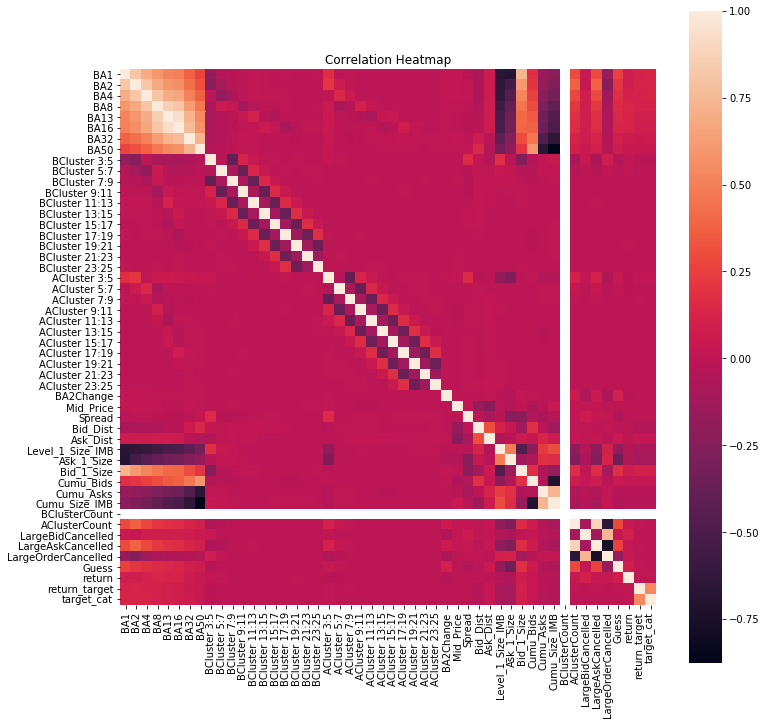

In [13]:
import seaborn as sns
fig, axs = plt.subplots(1, figsize = (12,12))
axs = sns.heatmap(feature_data.corr(), xticklabels=feature_data.columns, yticklabels=feature_data.columns, square=True)
axs.set_title('Correlation Heatmap')

In [14]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

feature_scaler = MinMaxScaler(feature_range=(-1, 1))

feature_to_scale = feature_data.drop(columns = ['return', 'return_target', 'target_cat'])

feature_scaler.fit(feature_to_scale)
print(feature_scaler.data_min_)

feature_norm = feature_scaler.transform(feature_to_scale)

# fig, ax = plt.subplots(5,2, figsize = (16,16))

# for i in range(5):
#     for j in range(2):
#         ax[i][j].plot(feature_norm[:,2*i+j], color = 'blue')
#         ax[i][j].set_title(feature_to_scale.columns[2*i+j])
        
#         ax_other = ax[i][j].twinx()
#         ax_other.plot(feature_norm[:,0], color = 'orange')
        
# fig.tight_layout()

# #check proper scaling with data_min_

[ 4.94559842e-06  3.29706561e-06  4.94559842e-06  4.94559842e-06
  4.94559842e-06  4.94559842e-06  4.94559842e-06  4.94559842e-06
  4.94559842e-06  4.94559842e-06  4.94559842e-06  4.94559842e-06
  4.94559842e-06  3.30307715e-06  3.29706561e-06  4.95461572e-06
  4.94559842e-06  4.94559842e-06  3.29706561e-06  4.94559842e-06
  3.29706561e-06  4.94559842e-06  4.94559842e-06  3.29706561e-06
  3.29706561e-06  4.94559842e-06  4.94559842e-06  4.94559842e-06
  4.94559842e-06  4.94559842e-06 -1.04935998e+05  6.57740500e+03
 -4.60517019e+00  1.22671229e+00  1.76301700e+00 -2.05546946e+02
 -1.84206807e+01 -1.84206807e+01  7.33031538e+00  1.35222726e+01
 -4.75791935e+02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.00000000e+00 -1.50000000e+01]


In [15]:
def rolling_window(a, window_size):
    shape = (a.shape[0] - window_size + 1, window_size) + a.shape[1:]
    strides = (a.strides[0],) + a.strides
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)


subsets = rolling_window(feature_norm,30)
X = subsets[:len(subsets)]

x_train = X[:700000]
x_test = X[700000:]

print(x_train.shape)
print(x_test.shape)
print(feature_norm.shape)

(700000, 30, 47)
(209317, 30, 47)
(909346, 47)


In [18]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
encoder.fit(feature_data['target_cat'].values.reshape(-1,1))

cat = encoder.transform(feature_data['target_cat'].values.reshape(-1,1)).toarray()

Y = cat[29:] # rolling window size 10, indices 0-9

y_train = Y[:700000]
y_test = Y[700000:]

print(Y.shape)
print(y_test.shape)
print(y_train.shape)

(909317, 3)
(209317, 3)
(700000, 3)


In [20]:
import keras
from keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight

class_weights = [1.5, 0.5, 1.5] # give up and down higher weights to override possible focus on unchanged from unbalanced classes

model3 = keras.models.Sequential()
model3.add(keras.layers.LSTM(80))
model3.add(keras.layers.Dense(64, activation = 'relu'))
model3.add(keras.layers.Dense(3, activation = 'softmax'))
callbacks = [ModelCheckpoint(filepath='best_model.h5', monitor='val_categorical_accuracy', save_best_only=True)]

model3.compile(optimizer = keras.optimizers.Adam(lr = 0.001, decay = 1e-5),
               loss='categorical_crossentropy',
               metrics = ['categorical_accuracy'])

history = model3.fit(x=x_train,
                    y=y_train,
                    batch_size=100,
                    epochs=15,
                    verbose=1,
                    callbacks=callbacks,
                    validation_data=(x_test, y_test),
                     class_weight=class_weights)
model3.summary()

Train on 700000 samples, validate on 209317 samples
Epoch 1/15
700000/700000 [==============================] - 234s 334us/step - loss: 0.4605 - categorical_accuracy: 0.8041 - val_loss: 0.4437 - val_categorical_accuracy: 0.8122
Epoch 2/15
700000/700000 [==============================] - 260s 372us/step - loss: 0.4351 - categorical_accuracy: 0.8108 - val_loss: 0.4288 - val_categorical_accuracy: 0.8143
Epoch 3/15
700000/700000 [==============================] - 303s 433us/step - loss: 0.4254 - categorical_accuracy: 0.8131 - val_loss: 0.4246 - val_categorical_accuracy: 0.8151
Epoch 4/15
700000/700000 [==============================] - 304s 434us/step - loss: 0.4191 - categorical_accuracy: 0.8145 - val_loss: 0.4201 - val_categorical_accuracy: 0.8159
Epoch 5/15
700000/700000 [==============================] - 313s 447us/step - loss: 0.4143 - categorical_accuracy: 0.8163 - val_loss: 0.4180 - val_categorical_accuracy: 0.8152
Epoch 6/15
700000/700000 [==============================] - 339s 484

[[ 10473.   6895.   8080.]
 [  3669. 147505.   4249.]
 [  6907.   9051.  12488.]]


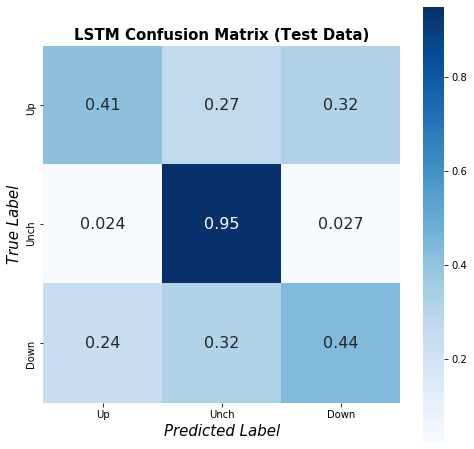

In [21]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(np.argmax(y_test,1), np.argmax(model3.predict(x_test),1))
cm = cm.astype(float)

print(cm)

cm[0,:] = np.true_divide(cm[0,:], cm[0,:].sum())
cm[1,:] = np.true_divide(cm[1,:], cm[1,:].sum())
cm[2,:] = np.true_divide(cm[2,:], cm[2,:].sum())


import seaborn as sns

fig, axs = plt.subplots(1, figsize = (8,8))
axs = sns.heatmap(cm, xticklabels=['Up','Unch', 'Down'], 
                  yticklabels=['Up','Unch', 'Down'], annot = True,square=True, 
                  cmap=plt.cm.Blues, annot_kws={"size":16})

axs.set_title("LSTM Confusion Matrix (Test Data)", fontsize = 15, weight = 'bold')
axs.set_xlabel('Predicted Label', fontsize = 15, style = 'italic')
axs.set_ylabel('True Label', fontsize = 15, style = 'italic')
fig.savefig('CM__LSTM_new.png')